In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

In [2]:
inputdir = Path('inputfiles')
figuredir = Path('output')
outputdir = Path('../1_Export')
if not figuredir.is_dir(): figuredir.mkdir()

# Read data

## Read additional files used for post-processing

In [3]:
meetpuntenfile = inputdir / 'Meetpunten.xlsx'
meetp = pd.read_excel(meetpuntenfile, index_col=3)
meetp = meetp[~meetp.index.duplicated(keep='first')]
meetp = meetp[~meetp['Locatie'].str.contains('#')]  # Ignore output starting with #
# meetp.head()

In [4]:
longitudinalrkmfile = inputdir / 'Longitudinal_rkm.xlsx'
rkm = pd.read_excel(longitudinalrkmfile, index_col=None)
# rkm.head(50)

## Read model output

In [5]:
model_output = pd.read_pickle(outputdir / 'Observations.pkl') 
Q_Lobith = pd.read_csv(r'../../1_Laterals/3_Combineren_analyseren/Lobith.csv', index_col=0, header=None)[1]
model_output.index = Q_Lobith.values
model_output.head()
# model_output = model_output.T.reset_index()
# model_output['simulation'], model_output['bedlevel'] = model_output['level_0'].str.split('_', 1).str

# model_output.drop('level_0', axis=1, inplace=True)
# model_output.rename(mapper={'level_1': 'quantity', 'level_2': 'station'}, axis=1, inplace=True)
# model_output.set_index(['simulation', 'bedlevel', 'quantity', 'station'], inplace=True)
# model_output = model_output.T

# model_output.head()

simulation    AfvoerIJssel                                            \
bedlevel           bed2018                                             
quantity       water_level                                             
station    Q-LobithPannkop LMW.Lobith LMW.PanKop 863.00_BR 865.00_BR   
500.0             5.804996   5.959033   5.703144  5.904165  5.784474   
550.0             5.950469   6.105749   5.845367  6.050388  5.929467   
600.0             6.099160   6.254141   5.992129  6.198809  6.077927   
650.0             6.242830   6.397553   6.134077  6.342249  6.221392   
700.0             6.377161   6.532381   6.266330  6.476863  6.355436   

simulation                                                                  \
bedlevel                                                                     
quantity                                                                     
station    866.00_BR 867.00_BR 864.00_BR LMW.Lobith-haven SintAndriesboven   
500.0       5.745136  5.705937  5.832404         5.839379         0.850919   
550.0       5.888979  5.848270  5.978530         5.985595         0.921596   
600.0       6.036786  5.995104  6.127552         6.134631         1.003518   
650.0       6.179668  6.137118  6.271523         6.278615         1.087030   
700.0       6.312982  6.269446  6.406264         6.413404         1.169327   

simulation  ...  VrijAfstromend                                              \
bedlevel    ...         bed2050                                               
quantity    ... water_discharge                                               
station     ...       869.00_PK      Q-Waal Pannerdenschekop_WL   868.00_WA   
500.0       ...       87.936452  412.063561          412.063561  412.063561   
550.0       ...      100.033880  449.883340          449.883340  449.878968   
600.0       ...      112.225396  487.683328          487.683328  487.678661   
650.0       ...      125.073678  524.834940          524.834940  524.830398   
700.0       ...      138.463505  561.446768          561.446768  561.442386   

simulation                                                         \
bedlevel                                                            
quantity                                                            
station      869.00_WA    odd_055 stuurp. VeesWap1 Stuurpunt_pomp   
500.0       412.063562  31.813207              0.0            0.0   
550.0       449.873240  32.602818              0.0            0.0   
600.0       487.672550  36.467981              0.0            0.0   
650.0       524.824449  41.241394              0.0            0.0   
700.0       561.436647  46.035030              0.0            0.0   

simulation                             
bedlevel                               
quantity                               
station    VeesWap1_892 VeesWap1_8702  
500.0               0.0           0.0  
550.0               0.0           0.0  
600.0               0.0           0.0  
650.0               0.0           0.0  
700.0               0.0           0.0  

[5 rows x 9320 columns]

In [6]:
# Export afvoerverdeling
Afvoerverdeling = model_output.loc[:,pd.IndexSlice[:, ['bed2018', 'bed2050'], 'water_discharge', ['Q-Waal', 'Q-IJssel', 'Q-Nederrijn']]]
Afvoerverdeling.columns = Afvoerverdeling.columns.droplevel('quantity')
Afvoerverdeling = Afvoerverdeling.swaplevel(0,1, axis=1).sort_index(axis=1)

Afvoerverdeling.to_excel('Afvoerverdeling.xlsx')

In [7]:
# Gebruik de aangepaste versie
model_output_sel = model_output.drop(model_output.loc[:, pd.IndexSlice['AfvoerNederrijn', 'bed2050', :, :]].columns, axis=1)
model_output_sel = model_output_sel.rename(mapper={'AfvoerNederrijnAangepast': 'AfvoerNederrijn'}, level='simulation', axis=1)

In [8]:
# Combineer alle simulaties naar 1 resultaat

Q_verdeling = pd.read_excel('../Afvoerverdeling_samenvoegen.xlsx', sheet_name='Resultaten', skiprows=2) # Inlezen weegfactoren
Q_verdeling.drop(0, inplace=True)

bed2018_sel = Q_verdeling.iloc[:, 28:32]
bed2018_sel.index = model_output_sel.index
bed2018_sel.columns = ['AfvoerIJssel', 'AfvoerNederrijn', 'Operationeel', 'VrijAfstromend']

bed2050_sel = Q_verdeling.iloc[:, 33:37]
bed2050_sel.index = model_output_sel.index
bed2050_sel.columns = ['AfvoerIJssel', 'AfvoerNederrijn', 'Operationeel', 'VrijAfstromend']

idx = pd.IndexSlice
D = {}
for c in bed2018_sel:
    if 'bed2018' not in D:
        D['bed2018'] = model_output_sel.loc[:, idx[c, 'bed2018']].multiply(bed2018_sel[c], axis=0)
    else:
        D['bed2018'] += model_output_sel.loc[:, idx[c, 'bed2018']].multiply(bed2018_sel[c], axis=0)
        
        
for c in bed2050_sel:
    if 'bed2050' not in D:
        D['bed2050'] = model_output_sel.loc[:, idx[c, 'bed2050']].multiply(bed2050_sel[c], axis=0)
    else:
        D['bed2050'] += model_output_sel.loc[:, idx[c, 'bed2050']].multiply(bed2050_sel[c], axis=0)
        
model_output_sel = pd.concat(D, axis=1)

D:\software\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


In [9]:
simulation_types = ['Operationeel', 'AfvoerNederrijn', 'AfvoerIJssel', 'VrijAfstromend']
bedlevels = ['bed2018', 'bed2050']
Q_levels = model_output.index
Q_levels_sel = Q_levels[np.linspace(0,len(Q_levels)-1,5).astype(int)]

In [10]:
waterlevel = model_output.xs('water_level', axis=1, level='quantity')
waterdepth = model_output.xs('water_depth', axis=1, level='quantity') 
bedlevel = (waterlevel - waterdepth)['AfvoerIJssel'].iloc[0,:]
bedlevel_change = bedlevel[bedlevels[1]] - bedlevel[bedlevels[0]]

In [11]:
all_rkm = rkm.T.values[:].flatten()
all_rkm = all_rkm[~(all_rkm.astype(str) == 'nan')]
rkm_data = model_output_sel.loc[:, idx[:,:,all_rkm]]
rkm_data = rkm_data.drop(rkm_data.loc[:, pd.IndexSlice[:, 'water_depth', :]].columns, axis=1)

rkm_data = rkm_data.reindex(axis=1, level='station', labels=all_rkm)
rkm_data.to_excel('RKM_data.xlsx')

# Longitudinal plots

In [12]:
linestyles = {'bed2018': '-', 'bed2050': ':'}
colors = {f'{Q:.0f}' : f'C{ii}' for (ii, Q) in enumerate(Q_levels_sel)}

In [13]:
# Create legends
def add_legends(ax, includeDischarge=True, includeBedlevel=True):
    if includeDischarge:
        legend_discharge = plt.legend([Line2D([], [], color=v) for k,v in colors.items()], colors.keys(), loc=2, bbox_to_anchor=(1,0.5), title='Afvoer Lobith')
    
    if includeBedlevel:
        legend_bedlevel  = plt.legend([Line2D([], [], linestyle=v, color='k') for k,v in linestyles.items()], linestyles.keys(), loc=3, bbox_to_anchor=(1,0), title='Bodemhoogte')
    if includeDischarge and includeBedlevel:
        ax.add_artist(legend_discharge)

In [14]:
def plotMeetpuntenForRKM(meetp, rkm):
    rkm = rkm[:-1]  # Skip last
    for il, l in enumerate(rkm):
        if l in meetp.index:
            plt.axvline(il, color='#777777',linewidth=1, linestyle='--')
            plt.annotate(meetp['Locatie'].loc[l], xy=(il, plt.gca().get_ylim()[1]), xytext = (-1,-2), textcoords='offset points',rotation='vertical',ha='right',va='top', color='#777777')

# Bodemhoogte

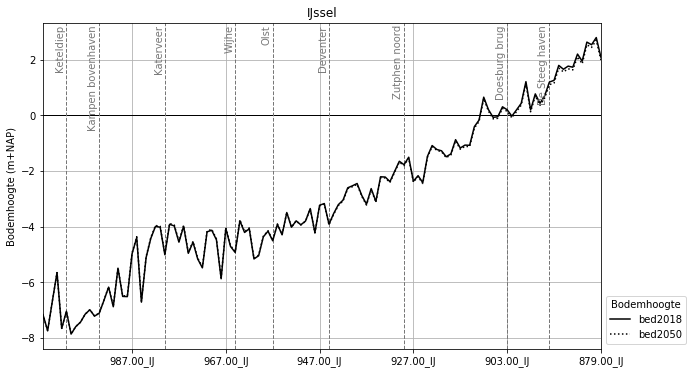

In [15]:
figuresubdir = figuredir / 'Longitudinal_bedlevel'
if not figuresubdir.is_dir(): figuresubdir.mkdir()

for s in rkm.columns:
    l = rkm[s].dropna()
    plt.close()
    f, ax = plt.subplots(figsize=(10,6), )
    for b in bedlevels:
        ls = linestyles[b]
                
        bedlevel[b][l].T.plot(legend=None, color='k', ls=ls, zorder=3, ax=ax)
        
    ax = plt.gca()
    ax.invert_xaxis()
    plt.axhline(0, zorder=2, color='k', lw=1)
    plotMeetpuntenForRKM(meetp, l)
    plt.ylabel('Bodemhoogte (m+NAP)')
    plt.xlabel('')
    plt.title(f'{s}')
    plt.grid()
    add_legends(ax, includeDischarge=False)
    plt.savefig(figuresubdir / f'Bedlevel_{s}.png', dpi=150, bbox_inches='tight')
    plt.savefig(figuresubdir / f'Bedlevel_{s}.svg', bbox_inches='tight')

# Bedlevel change

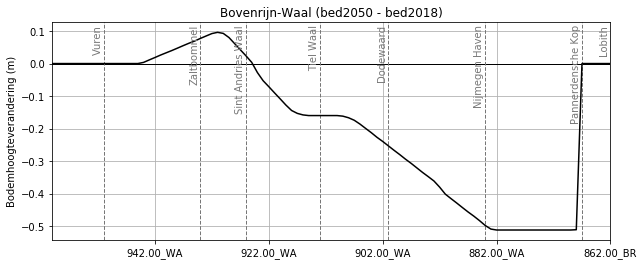

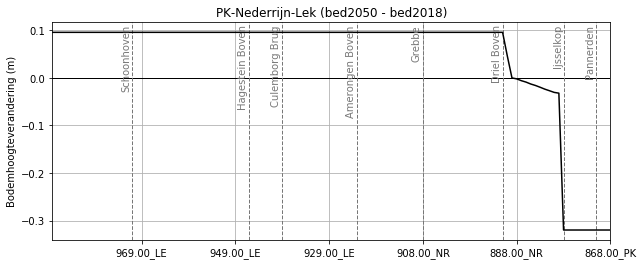

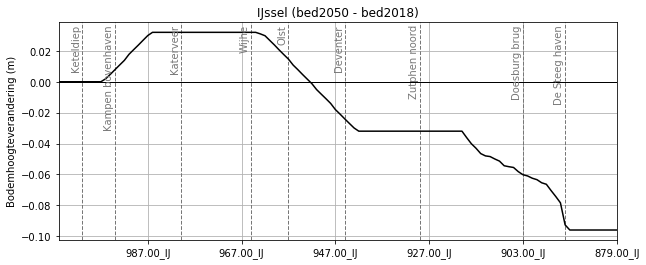

In [16]:
figuresubdir = figuredir / 'Longitudinal_bedlevel_change'
if not figuresubdir.is_dir(): figuresubdir.mkdir()

for s in rkm.columns:
    l = rkm[s].dropna()
#     plt.close()
    ls = linestyles[b]

    bedlevel_change[l].T.plot(legend=None, figsize=(10,4), color='k', zorder=3)
        
    ax = plt.gca()
    ax.invert_xaxis()
    plt.axhline(0, zorder=2, color='k', lw=1)
    plotMeetpuntenForRKM(meetp, l)
    plt.ylabel('Bodemhoogteverandering (m)')
    plt.xlabel('')
    plt.title(f'{s} ({bedlevels[1]} - {bedlevels[0]})')
    plt.grid()
    plt.savefig(figuresubdir / f'Bedlevel_change_{s}.png', dpi=150, bbox_inches='tight')
    plt.savefig(figuresubdir / f'Bedlevel_change_{s}.svg', bbox_inches='tight')
    plt.show()

# Longitudinal Waterlevel

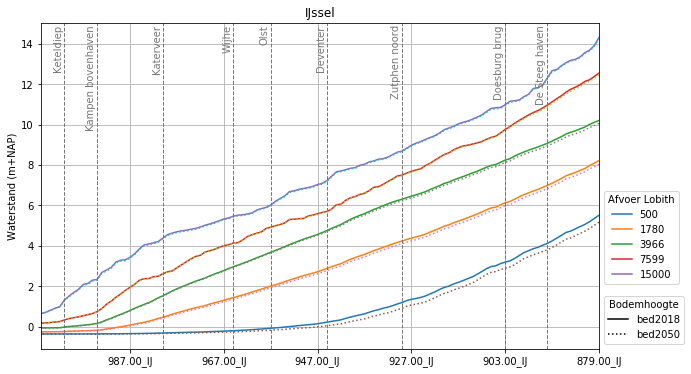

In [17]:
figuresubdir = figuredir / 'Longitudinal_waterlevel'
if not figuresubdir.is_dir(): figuresubdir.mkdir()


for s in rkm.columns:
    l = rkm[s].dropna()
    plt.close()
    for b in bedlevels:
        
        ls = linestyles[b]
        for Q in Q_levels_sel:
            model_output_sel[b]['water_level'][l].loc[Q].T.plot(legend=None, figsize=(10,6), ls=ls)
        
    ax = plt.gca()
    ax.invert_xaxis()
    plotMeetpuntenForRKM(meetp, l)
    plt.ylabel('Waterstand (m+NAP)')
    plt.xlabel('')
    plt.title(f'{s}')
    plt.grid()
    add_legends(ax)

    plt.savefig(figuresubdir / f'Waterlevel_{s}.png', dpi=150, bbox_inches='tight')
    plt.savefig(figuresubdir / f'Waterlevel_{s}.svg', bbox_inches='tight')

# Waterlevel including bed level

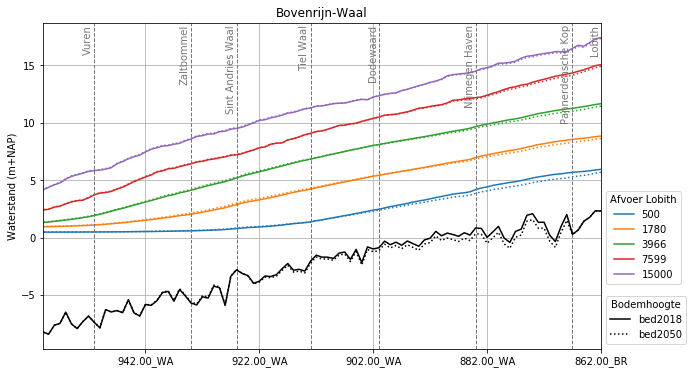

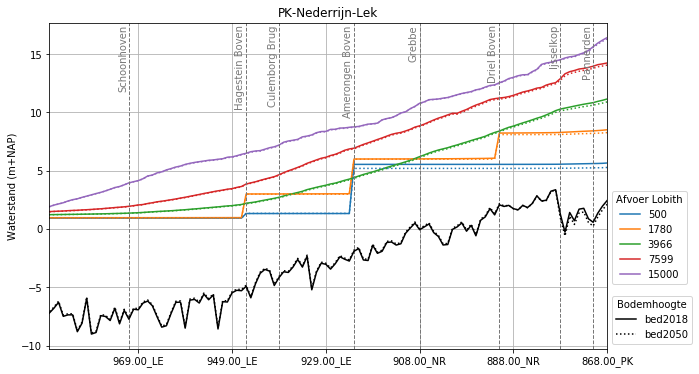

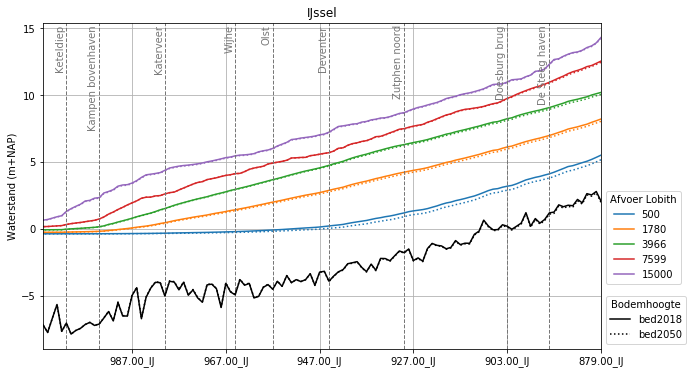

In [18]:
figuresubdir = figuredir / 'Longitudinal_waterlevel_withBed'
if not figuresubdir.is_dir(): figuresubdir.mkdir()


for s in rkm.columns:
    l = rkm[s].dropna()
    plt.close()
    for b in bedlevels:
        
        ls = linestyles[b]
        for Q in Q_levels_sel:
            c = colors[f'{Q:.0f}']
            model_output_sel[b]['water_level'][l].loc[Q].T.plot(legend=None, figsize=(10,6), ls=ls, color=c)

                
        bedlevel[b][l].T.plot(legend=None, color='k', ls=ls, zorder=3)
        
    ax = plt.gca()

    plotMeetpuntenForRKM(meetp, l)
    plt.ylabel('Waterstand (m+NAP)')
    plt.title(f'{s}')
    plt.grid()
        
    ax.invert_xaxis()
    add_legends(ax)
    plt.xlabel('')
    plt.savefig(figuresubdir / f'Waterlevel_{s}.png', dpi=150, bbox_inches='tight')
    plt.savefig(figuresubdir / f'Waterlevel_{s}.svg', bbox_inches='tight')
    plt.show()

# Longitudinal water level difference

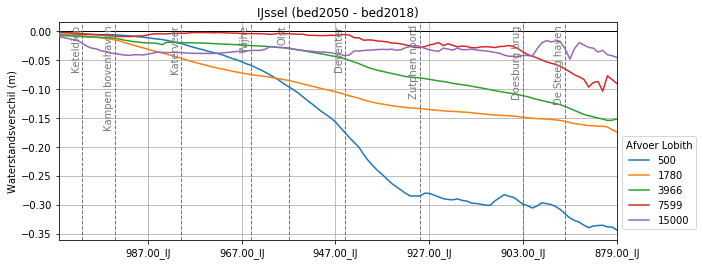

In [19]:
figuresubdir = figuredir / 'Longitudinal_waterlevel_diff'
if not figuresubdir.is_dir(): figuresubdir.mkdir()

dH = model_output_sel[bedlevels[1]]['water_level'] - model_output_sel[bedlevels[0]]['water_level']

for s in rkm.columns:
    l = rkm[s].dropna()
    plt.close()
    
    for Q in Q_levels_sel:
        c = colors[f'{Q:.0f}']
        dH[l].loc[Q].T.plot(legend=None, figsize=(10,4), color=c, zorder=3)

        
    ax = plt.gca()
    ax.invert_xaxis()
    plt.axhline(0, zorder=2, color='k', lw=1)
    plotMeetpuntenForRKM(meetp, l)
    plt.ylabel('Waterstandsverschil (m)')
    plt.xlabel('')
    plt.title(f'{s} ({bedlevels[1]} - {bedlevels[0]})')
    plt.grid()
    add_legends(ax, includeBedlevel=False)
    plt.savefig(figuresubdir / f'Waterlevel_difference_{s}.png', dpi=150, bbox_inches='tight')
    plt.savefig(figuresubdir / f'Waterlevel_difference_{s}.svg', bbox_inches='tight')


# Longitudinal discharge

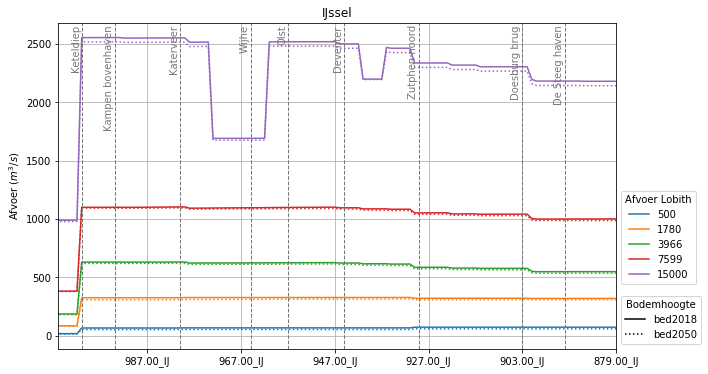

In [20]:
figuresubdir = figuredir / 'Longitudinal_discharge'
if not figuresubdir.is_dir(): figuresubdir.mkdir()
    
for s in rkm.columns:
    l = rkm[s].dropna()
    plt.close()
    

    for b in bedlevels:
        
        ls = linestyles[b]
        for Q in Q_levels_sel:
            c = colors[f'{Q:.0f}']
            model_output_sel[b]['water_discharge'][l].loc[Q].T.plot(legend=None, figsize=(10,6), ls=ls, color=c)

       
    ax = plt.gca()
    ax.invert_xaxis()
    plotMeetpuntenForRKM(meetp, l)
    plt.ylabel('Afvoer ($m^3/s$)')
    plt.xlabel('')
    plt.title(f'{s}')
    plt.grid()
    add_legends(ax)

    plt.savefig(figuresubdir / f'Discharge_{s}.png', dpi=150, bbox_inches='tight')
    plt.savefig(figuresubdir / f'Discharge_{s}.svg', bbox_inches='tight')

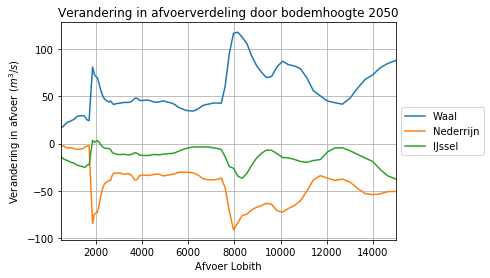

In [75]:
figuresubdir = figuredir / 'Discharge_distribution'
if not figuresubdir.is_dir(): figuresubdir.mkdir()

locations = ['Q-Waal', 'Q-Nederrijn','Q-IJssel']
data = model_output_sel[bedlevels[1]]['water_discharge'][locations] - model_output_sel[bedlevels[0]]['water_discharge'][locations]

data.plot()
plt.title(f'Verandering in afvoerverdeling door bodemhoogte 2050')
plt.ylabel('Verandering in afvoer ($m^3/s$)')
plt.xlabel('Afvoer Lobith')
plt.grid()
plt.legend(locations_name, loc=6, bbox_to_anchor=(1,0.5))

plt.savefig(figuresubdir / f'Dischargedistribution_change.png', dpi=150, bbox_inches='tight')
plt.savefig(figuresubdir / f'Dischargedistribution_change.svg', bbox_inches='tight')

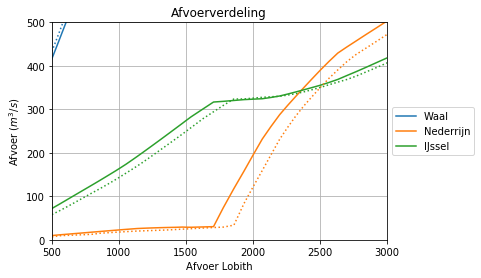

In [74]:
f, ax = plt.subplots()
linestylestions = ['Q-Waal', 'Q-Nederrijn','Q-IJssel']
for b in bedlevels:
    data = model_output_sel[b]['water_discharge'][locations]

    data.plot(ls=linestyles[b], ax=ax, color=['C0', 'C1', 'C2'])
plt.title(f'Afvoerverdeling')
plt.ylabel('Afvoer ($m^3/s$)')
plt.xlabel('Afvoer Lobith')
plt.grid()
plt.legend(locations_name, loc=6, bbox_to_anchor=(1,0.5))

plt.savefig(figuresubdir / f'Dischargedistribution.png', dpi=150, bbox_inches='tight')
plt.savefig(figuresubdir / f'Dischargedistribution.svg', bbox_inches='tight')

plt.xlim(500, 3000)
plt.ylim(0, 500)


plt.savefig(figuresubdir / f'Dischargedistribution_low.png', dpi=150, bbox_inches='tight')
plt.savefig(figuresubdir / f'Dischargedistribution_low.svg', bbox_inches='tight')


# Heatmaps

In [44]:
def plotMeetpuntenForRKM_heatmap(meetp, rkm, dil=1):
    rkm = rkm[:-1]  # Skip last
    for il, l in enumerate(rkm):
        if l in meetp.index:
            plt.axvline(il+dil, color='#777777',linewidth=1, linestyle='--')
            plt.annotate(meetp['Locatie'].loc[l], xy=(il+dil, plt.gca().get_ylim()[1]), xytext = (-1,-2), textcoords='offset points',rotation='vertical',ha='right',va='top', color='#777777')

In [45]:
figuresubdir = figuredir / 'Heatmaps'
if not figuresubdir.is_dir(): figuresubdir.mkdir()

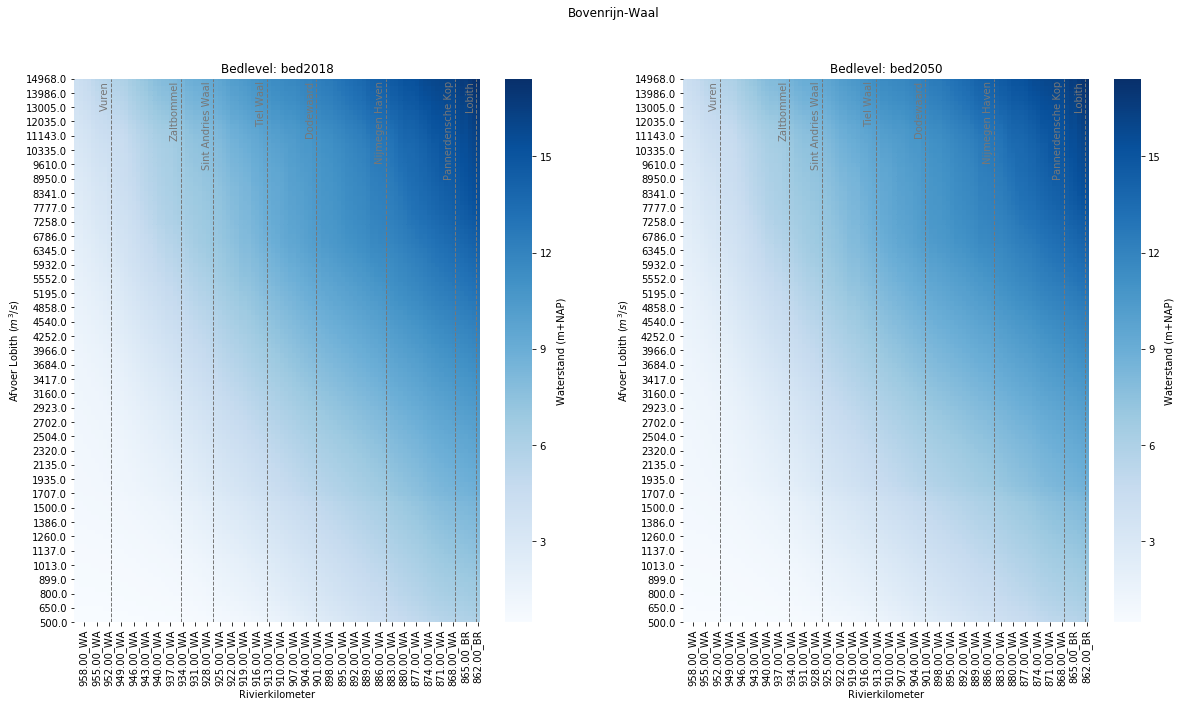

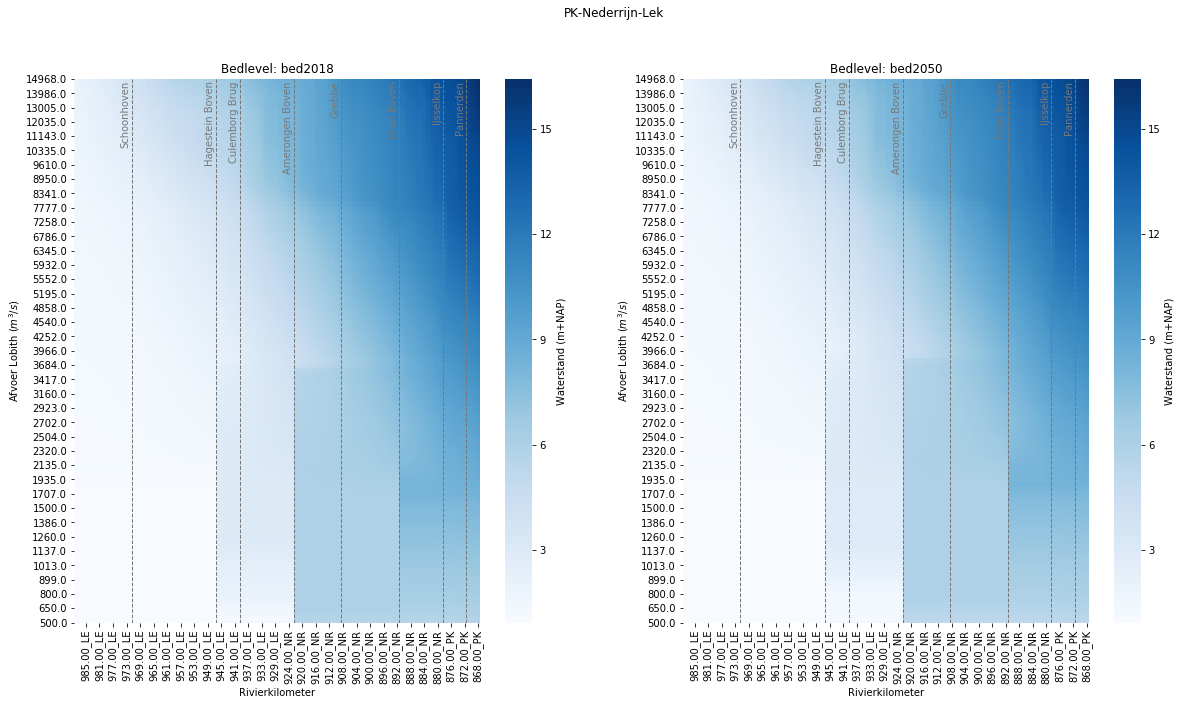

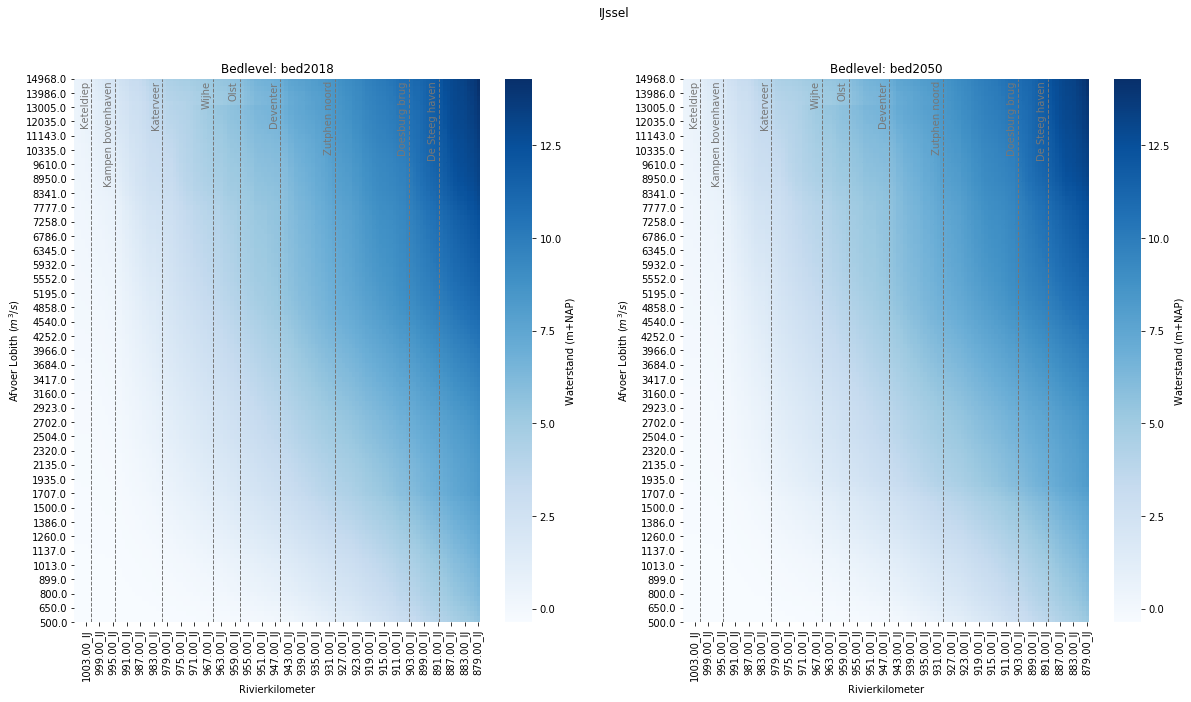

In [46]:
for s in rkm.columns:
    l = rkm[s].dropna()

    f, axi = plt.subplots(ncols=2, figsize=(20,10))
    vmin, vmax = None, None
    for ax, b in zip(axi, bedlevels):
        plt.sca(ax)
        data = model_output_sel[b]['water_level'][l]
        if not vmin: 
            vmin = data.min().min()
            vmax = data.max().max()
        sns.heatmap(data, cmap='Blues', ax=ax, vmin=vmin, vmax=vmax, cbar_kws={'label': 'Waterstand (m+NAP)'})
        ax.invert_xaxis()
        ax.invert_yaxis()
        ax.set_title(f'Bedlevel: {b}')
        plotMeetpuntenForRKM_heatmap(meetp, l)
        plt.ylabel('Afvoer Lobith ($m^3/s$)')
        plt.xlabel('Rivierkilometer')
    plt.suptitle(s)
    plt.savefig(figuresubdir / f'Water_level_{s}.png', dpi=300, bbox_inches='tight')


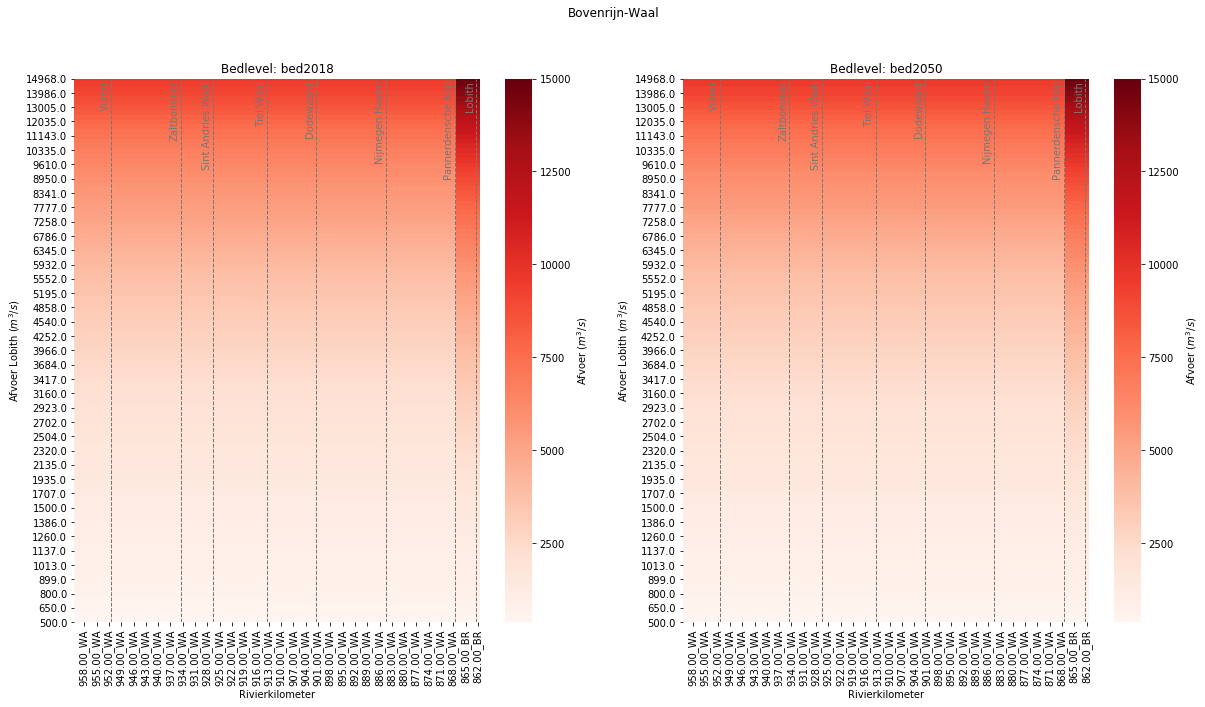

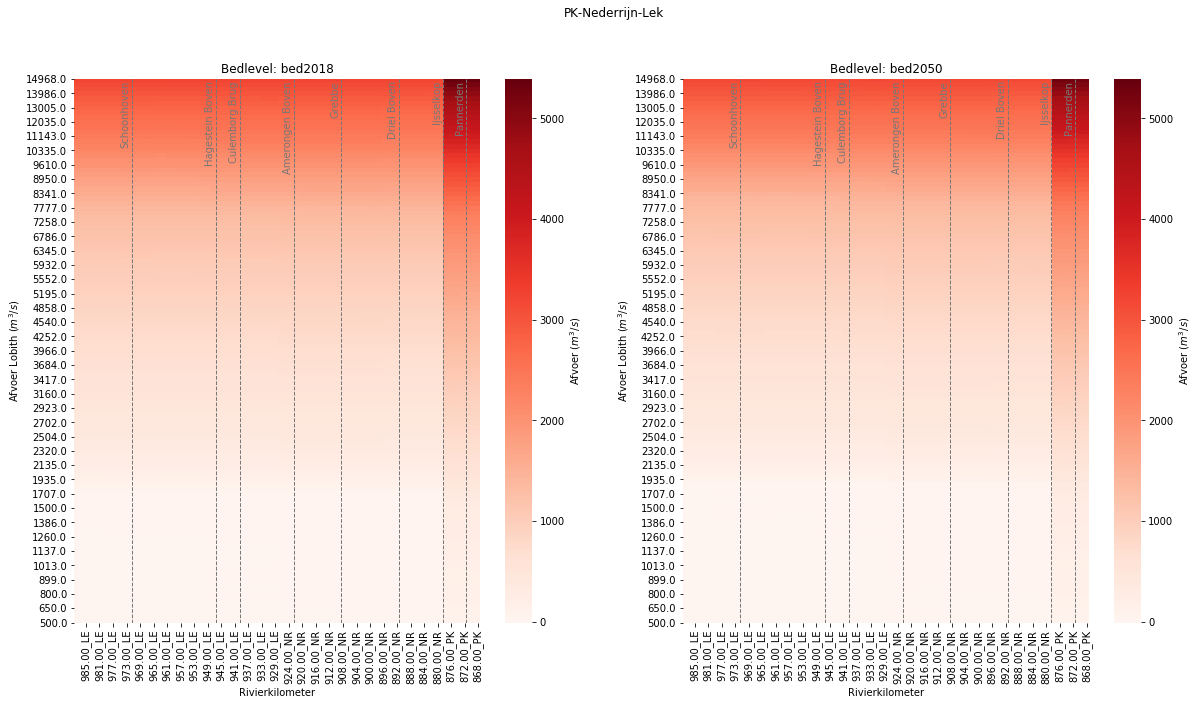

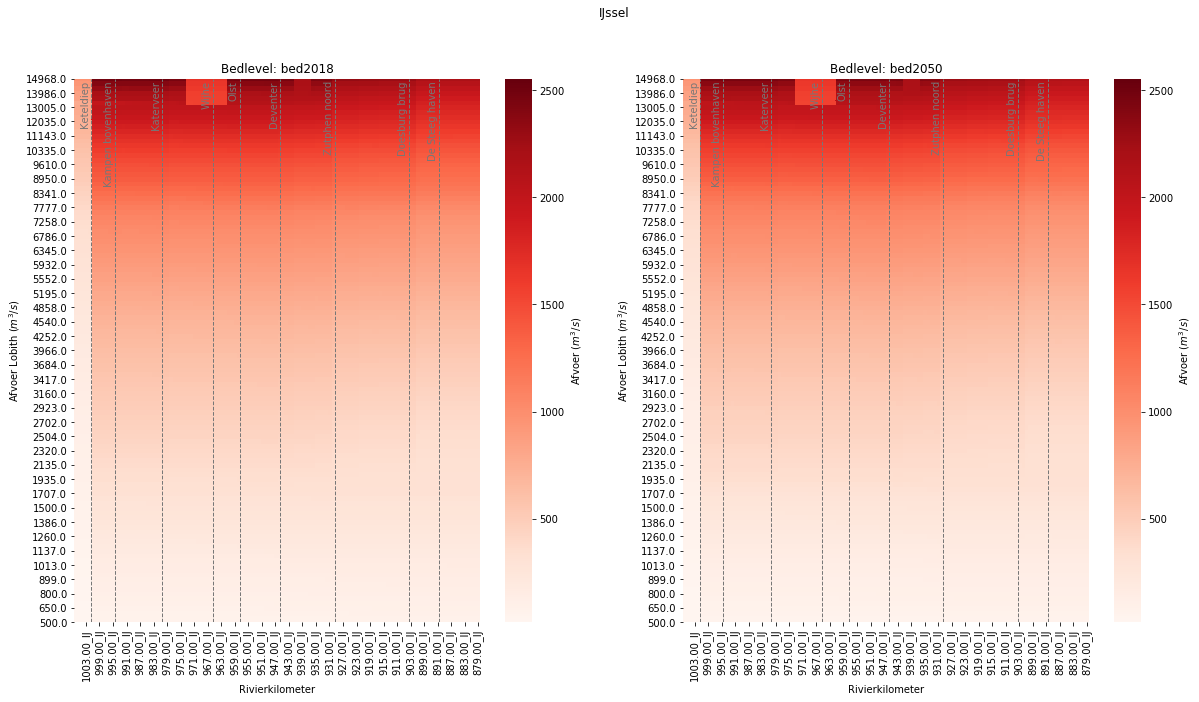

In [47]:
for s in rkm.columns:
    l = rkm[s].dropna()

    f, axi = plt.subplots(ncols=2, figsize=(20,10))
    vmin, vmax = None, None
    for ax, b in zip(axi, bedlevels):
        plt.sca(ax)
        data = model_output_sel[b]['water_discharge'][l]
        if not vmin: 
            vmin = data.min().min()
            vmax = data.max().max()
        sns.heatmap(data, cmap='Reds', ax=ax, vmin=vmin, vmax=vmax, cbar_kws={'label': 'Afvoer ($m^3/s$)'})
        ax.invert_xaxis()
        ax.invert_yaxis()
        ax.set_title(f'Bedlevel: {b}')
        plotMeetpuntenForRKM_heatmap(meetp, l.iloc[:-4])
        plt.ylabel('Afvoer Lobith ($m^3/s$)')
        plt.xlabel('Rivierkilometer')
    plt.suptitle(s)
    plt.savefig(figuresubdir / f'Discharge_{s}.png', dpi=300, bbox_inches='tight')


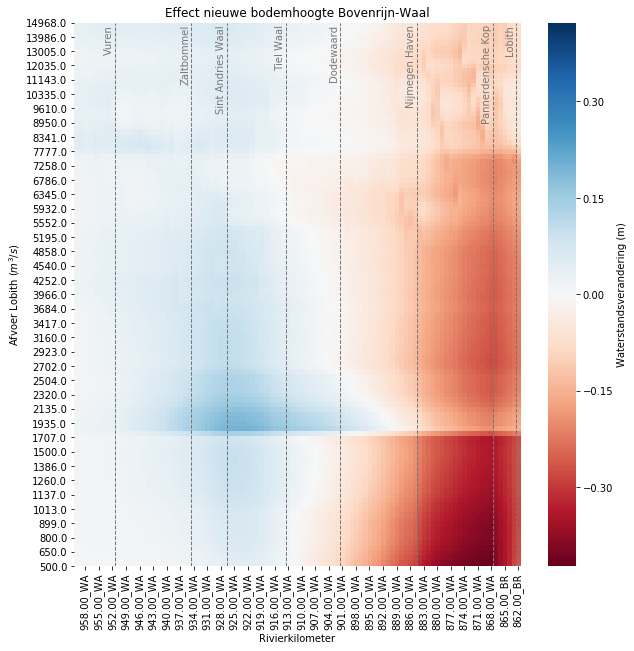

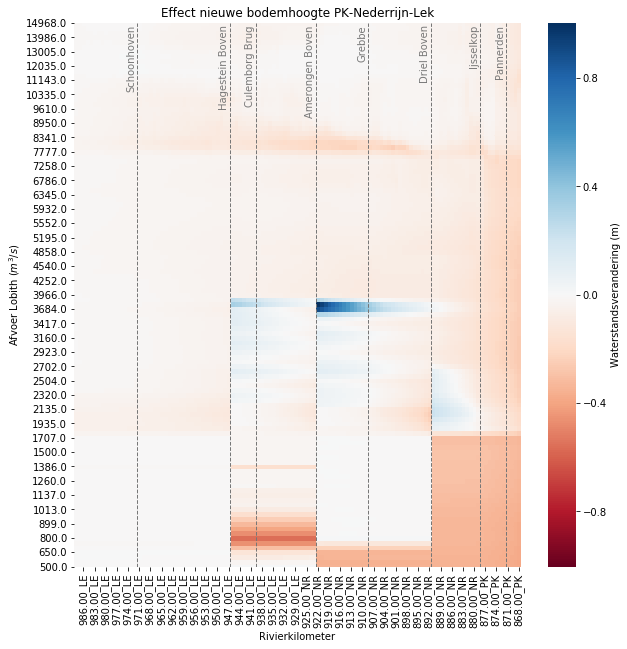

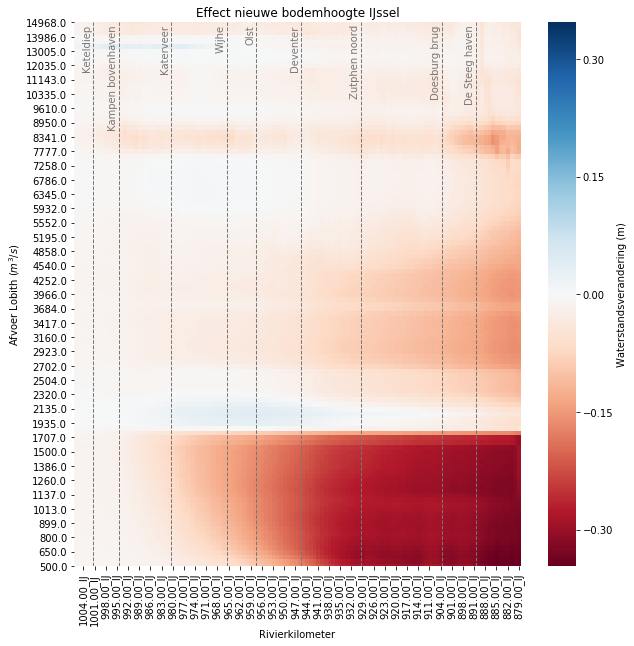

In [48]:
for s in rkm.columns:
    l = rkm[s].dropna()

    f, ax = plt.subplots(ncols=1, figsize=(10,10))
    plt.sca(ax)
    data = model_output_sel[bedlevels[1]]['water_level'][l] - model_output_sel[bedlevels[0]]['water_level'][l]
    vmax = data.abs().max().max()
    vmin = -vmax
    sns.heatmap(data, cmap='RdBu', ax=ax, vmin=vmin, vmax=vmax, cbar_kws={'label': 'Waterstandsverandering (m)'})
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.set_title(f'Effect nieuwe bodemhoogte {s}')
    plotMeetpuntenForRKM_heatmap(meetp, l)
    plt.ylabel('Afvoer Lobith ($m^3/s$)')
    plt.xlabel('Rivierkilometer')
    plt.savefig(figuresubdir / f'Water_level_change_{s}.png', dpi=300, bbox_inches='tight')


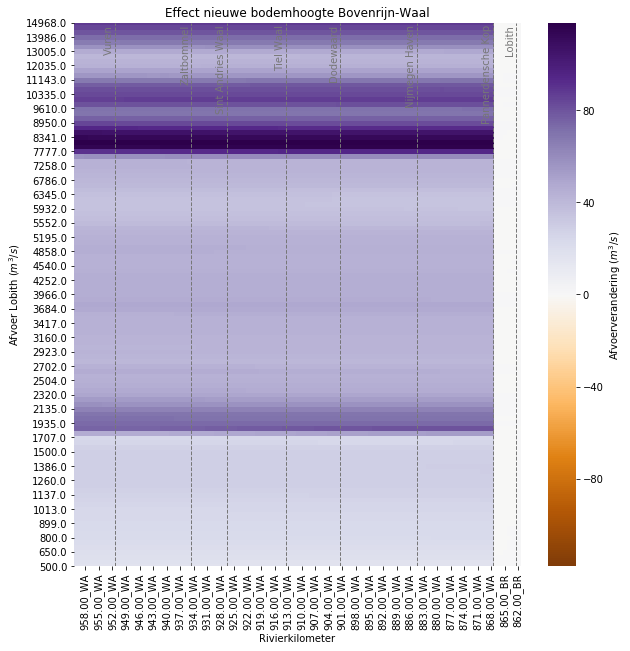

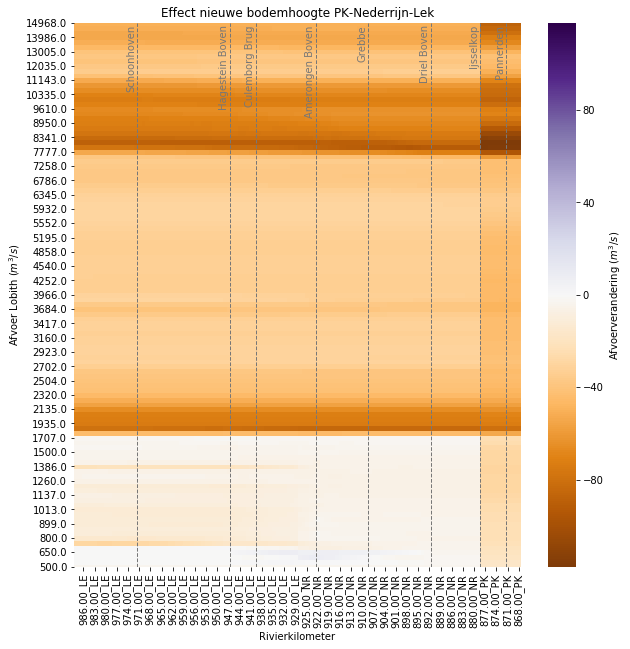

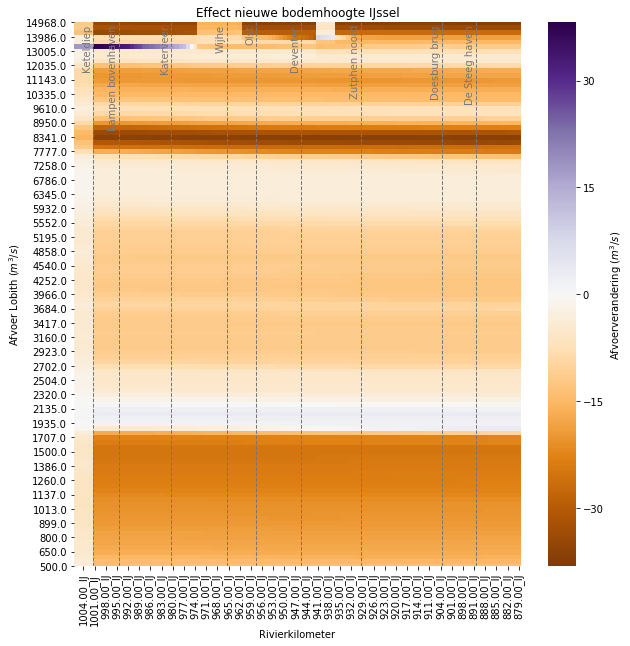

In [49]:
for s in rkm.columns:
    l = rkm[s].dropna()

    f, ax = plt.subplots(ncols=1, figsize=(10,10))
    plt.sca(ax)
    data = model_output_sel[bedlevels[1]]['water_discharge'][l] - model_output_sel[bedlevels[0]]['water_discharge'][l]
    vmax = data.abs().max().max()
    vmin = -vmax
    sns.heatmap(data, cmap='PuOr', ax=ax, vmin=vmin, vmax=vmax, cbar_kws={'label': 'Afvoerverandering ($m^3/s$)'})
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.set_title(f'Effect nieuwe bodemhoogte {s}')
    plotMeetpuntenForRKM_heatmap(meetp, l)
    plt.ylabel('Afvoer Lobith ($m^3/s$)')
    plt.xlabel('Rivierkilometer')
    plt.savefig(figuresubdir / f'Discharge_change_{s}.png', dpi=300, bbox_inches='tight')


# QH to Lobith

In [27]:
figuresubdir = figuredir / 'Heatmaps_QH'
if not figuresubdir.is_dir(): figuresubdir.mkdir()

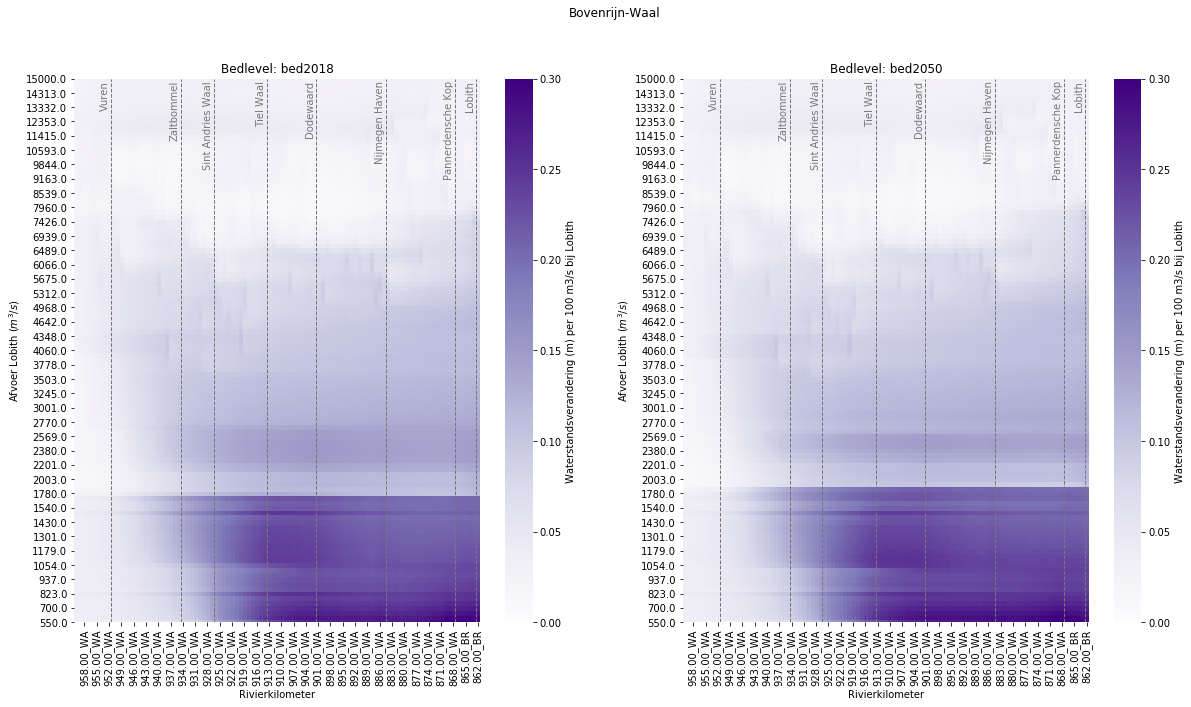

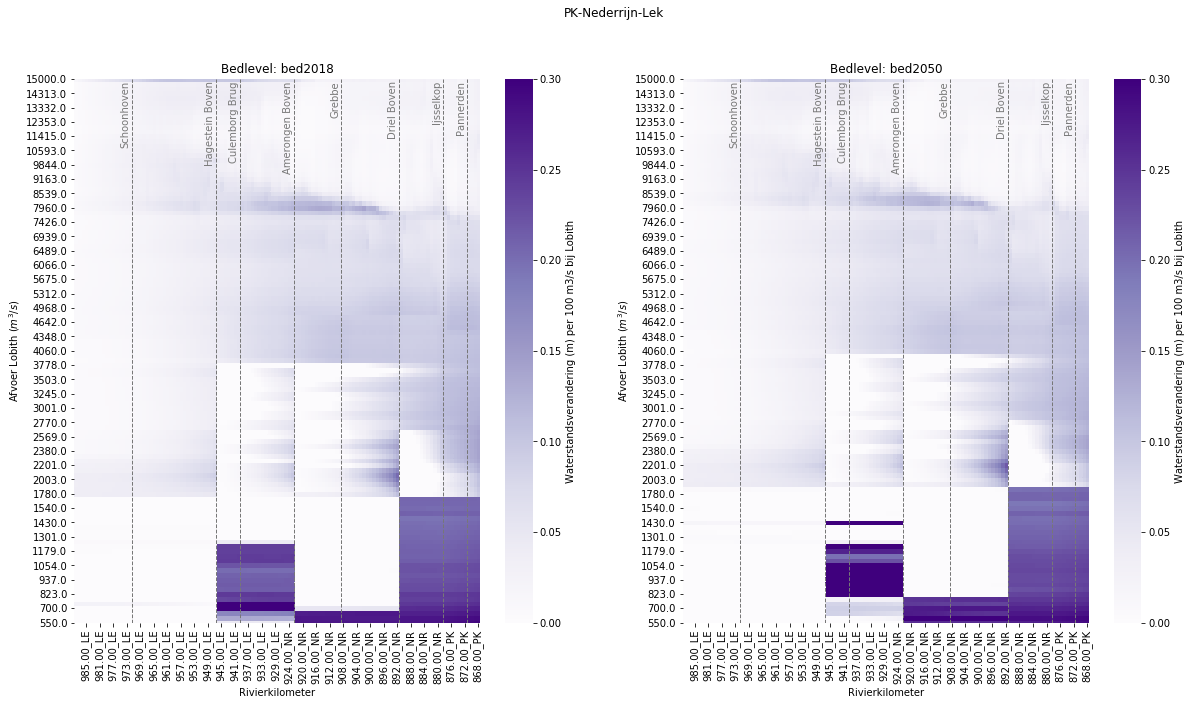

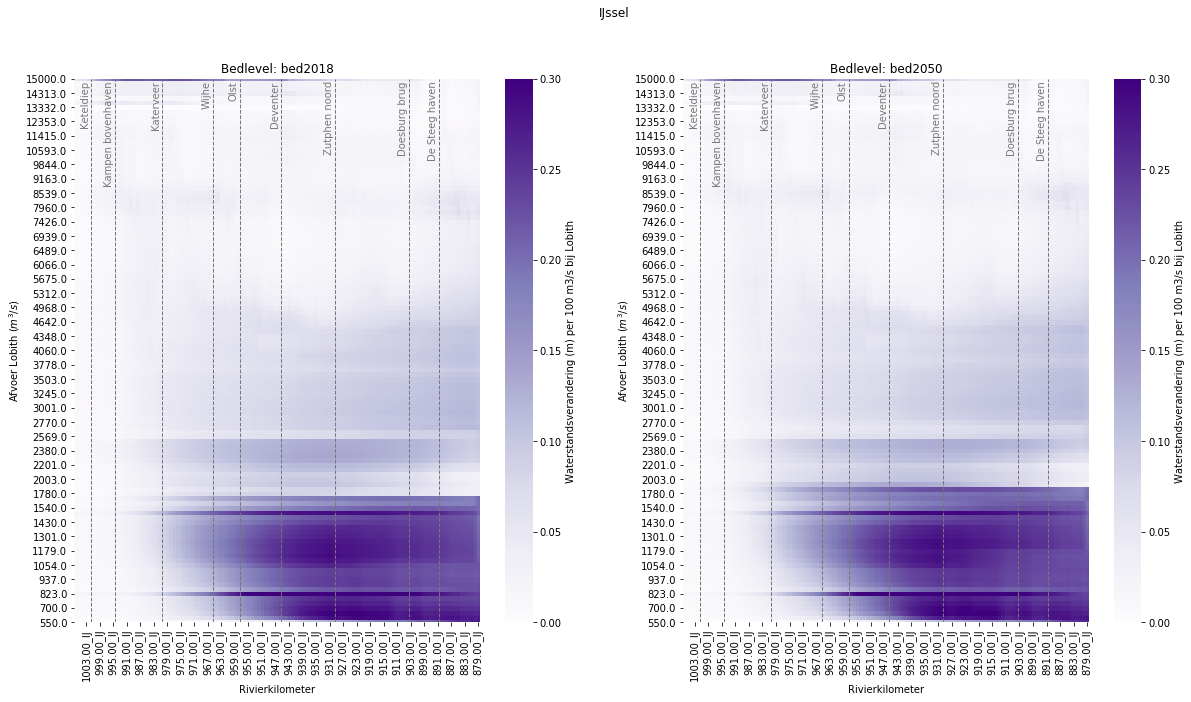

In [28]:
# Increase in waterlevels per discharge at Lobith
for s in rkm.columns:
    l = rkm[s].dropna()

    f, axi = plt.subplots(ncols=2, figsize=(20,10))
    for ax, b in zip(axi, bedlevels):
        plt.sca(ax)
        data = model_output_sel[b]['water_level'][l].diff(axis=0).drop(500).divide(model_output_sel.index[1:] - model_output_sel.index[:-1], axis=0) * 100
        sns.heatmap(data, cmap='Purples', ax=ax, vmin=0, vmax=0.3, cbar_kws={'label': 'Waterstandsverandering (m) per 100 m3/s bij Lobith'})
        ax.invert_xaxis()
        ax.invert_yaxis()
        ax.set_title(f'Bedlevel: {b}')
        plotMeetpuntenForRKM_heatmap(meetp, l)
        plt.ylabel('Afvoer Lobith ($m^3/s$)')
        plt.xlabel('Rivierkilometer')
    plt.suptitle(s)
    plt.savefig(figuresubdir / f'Water_level_change_dischargeLobith_{s}.png', dpi=300, bbox_inches='tight')


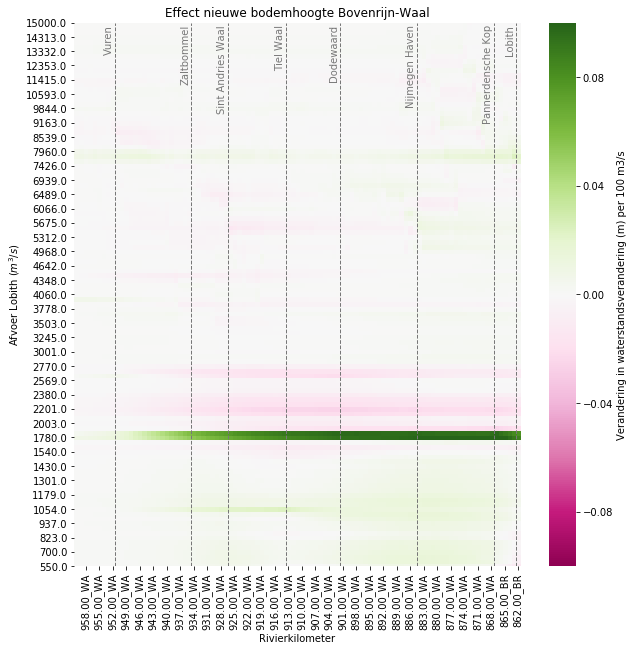

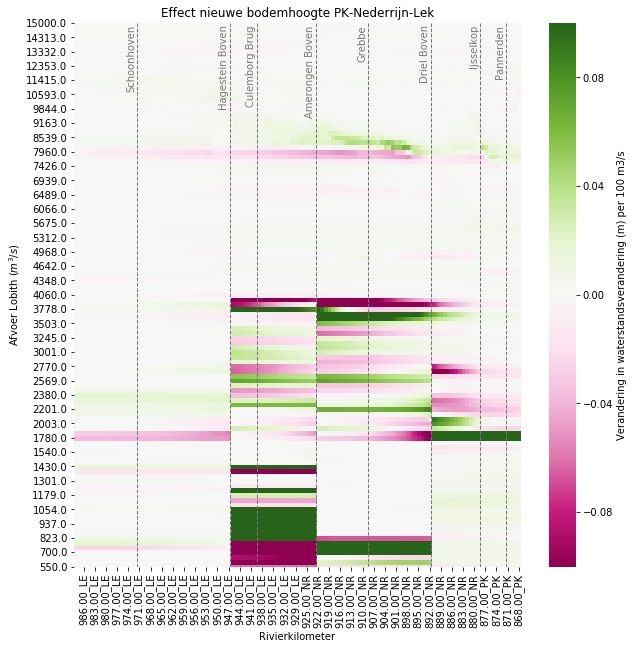

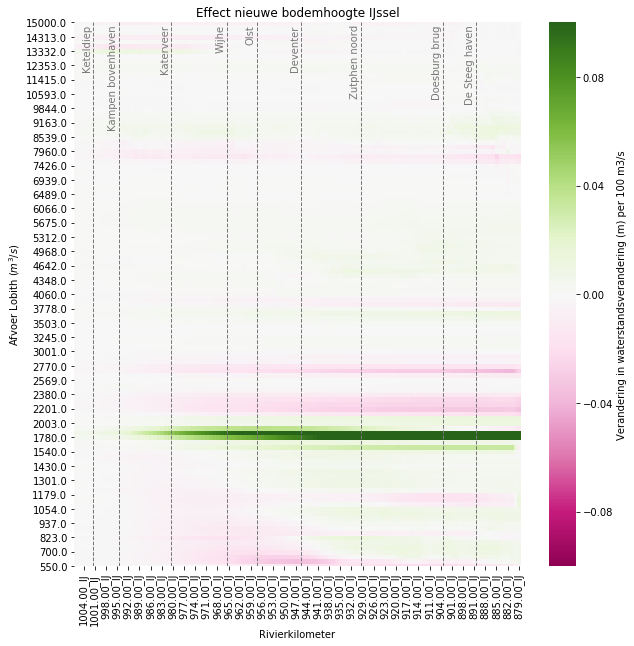

In [29]:
# Change in increase in waterlevels per discharge at Lobith
# (Difference plot of the figures before)

for s in rkm.columns:
    l = rkm[s].dropna()

    f, ax = plt.subplots(ncols=1, figsize=(10,10))
    plt.sca(ax)
    data_bed2018 = model_output_sel[bedlevels[0]]['water_level'][l].diff(axis=0).drop(500).divide(model_output_sel.index[1:] - model_output_sel.index[:-1], axis=0) * 100
    data_bed2050 = model_output_sel[bedlevels[1]]['water_level'][l].diff(axis=0).drop(500).divide(model_output_sel.index[1:] - model_output_sel.index[:-1], axis=0) * 100
    data = data_bed2050 - data_bed2018
    sns.heatmap(data, cmap='PiYG', ax=ax, vmin=-0.1, vmax=0.1, cbar_kws={'label': 'Verandering in waterstandsverandering (m) per 100 m3/s'})
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.set_title(f'Effect nieuwe bodemhoogte {s}')
    plotMeetpuntenForRKM_heatmap(meetp, l)
    plt.ylabel('Afvoer Lobith ($m^3/s$)')
    plt.xlabel('Rivierkilometer')
    plt.savefig(figuresubdir / f'Water_level_change_dischargeLobith_{s}_change.png', dpi=300, bbox_inches='tight')


# QH local

In [30]:
Q_range = np.arange(0, 15000+0.1, 20)
QH = {}
for b in bedlevels:
    QH[b] = pd.DataFrame(index=Q_range)
    Q_bed = model_output_sel[b]['water_discharge']
    H_bed = model_output_sel[b]['water_level']
    
    for station in Q_bed:
        H = np.interp(Q_range, Q_bed[station], H_bed[station], left=np.nan, right=np.nan)
        QH[b][station] = H

In [34]:
for station in [s for s in model_output.columns.levels[-1] if 'LMW' in s]:
    for b in bedlevels:
        QH[b][station].dropna(how='all').plot(figsize=(6,6))
    (QH[bedlevels[1]][station] - QH[bedlevels[0]][station]).dropna(how='all').plot(secondary_y=True)
    ax = plt.gca().left_ax
    
    ax.set_xlabel('Afvoer ($m^3/s$)')
    ax.set_ylabel('Waterstand (m+NAP)')
    ax.grid()
    ax.right_ax.set_ylabel('Waterstandsverandering (m)')
    plt.title(station)
    plt.legend([ax.get_lines()[0], ax.get_lines()[1], ax.right_ax.get_lines()[0]], ['QH_bed2018', 'QH_bed2050', 'verschil'], loc='lower right')
    plt.savefig(figuresubdir / f'QH_{station}.png', dpi=300, bbox_inches='tight')
    plt.savefig(figuresubdir / f'QH_{station}.svg', bbox_inches='tight')
    plt.close()

D:\software\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1085: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)
D:\software\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1085: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)
D:\software\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1085: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


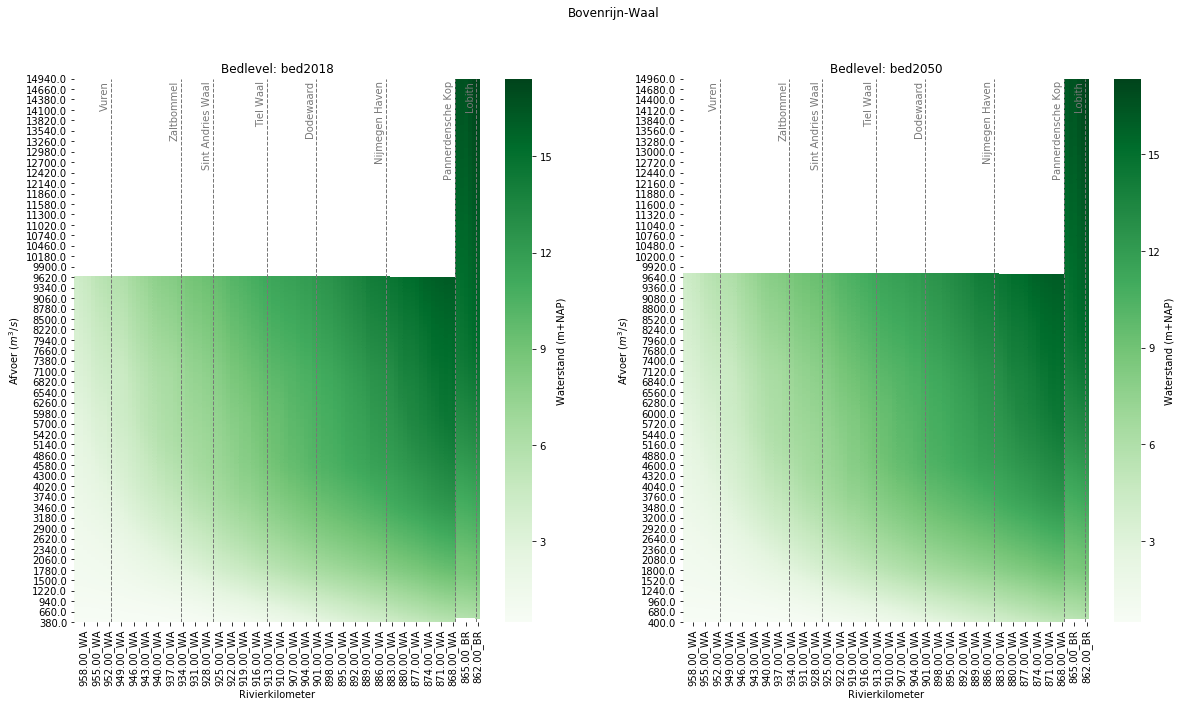

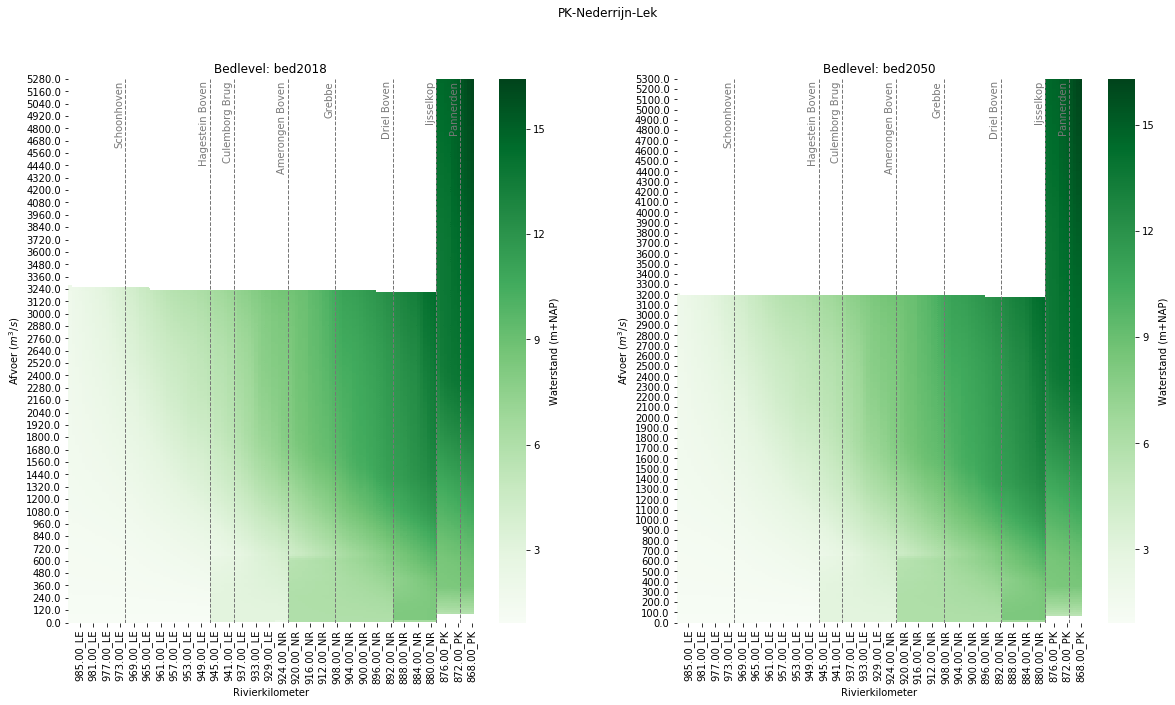

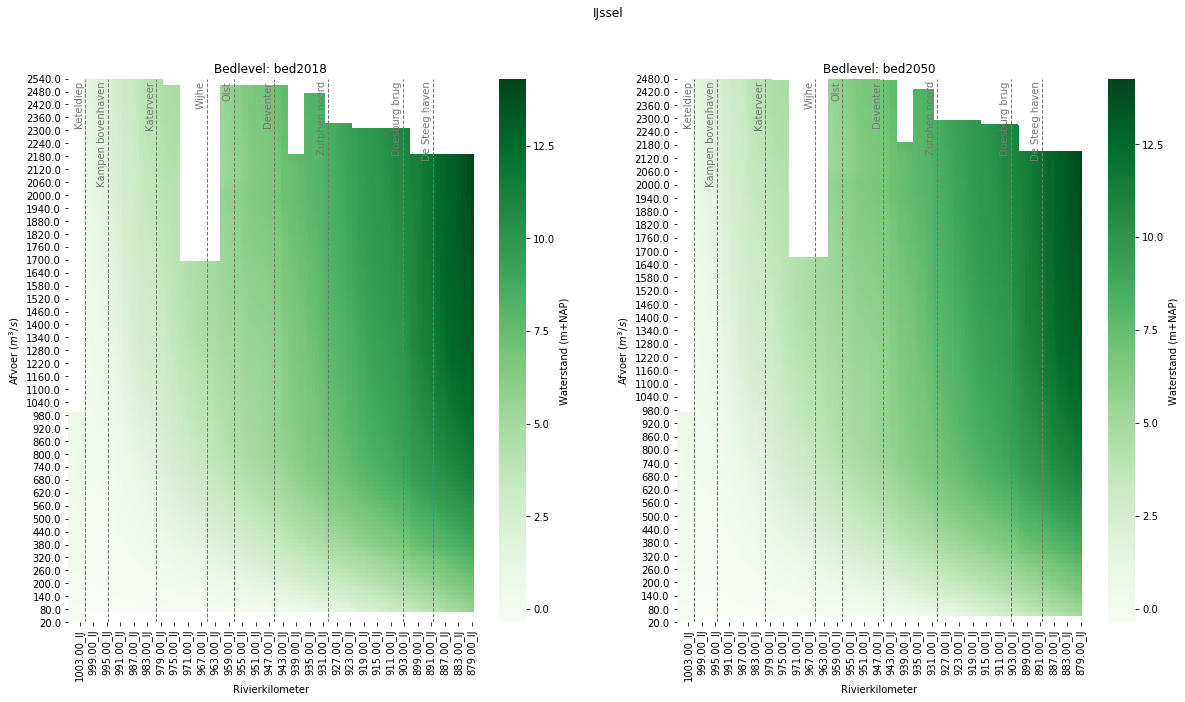

In [32]:
# Plot the change dH per dQ. Is there a discontinuity at 8000 m3/s?
for s in rkm.columns:
    l = rkm[s].dropna()

    f, axi = plt.subplots(ncols=2, figsize=(20,10))
    for ax, b in zip(axi, bedlevels):
        plt.sca(ax)
        data = QH[b][l].dropna(how='all')
        sns.heatmap(data, cmap='Greens', ax=ax, cbar_kws={'label': 'Waterstand (m+NAP)'})
        ax.invert_xaxis()
        ax.invert_yaxis()
        ax.set_title(f'Bedlevel: {b}')
        plotMeetpuntenForRKM_heatmap(meetp, l)
        plt.ylabel('Afvoer ($m^3/s$)')
        plt.xlabel('Rivierkilometer')
    plt.suptitle(s)
    plt.savefig(figuresubdir / f'Heatmap_QH_{s}.png', dpi=300, bbox_inches='tight')


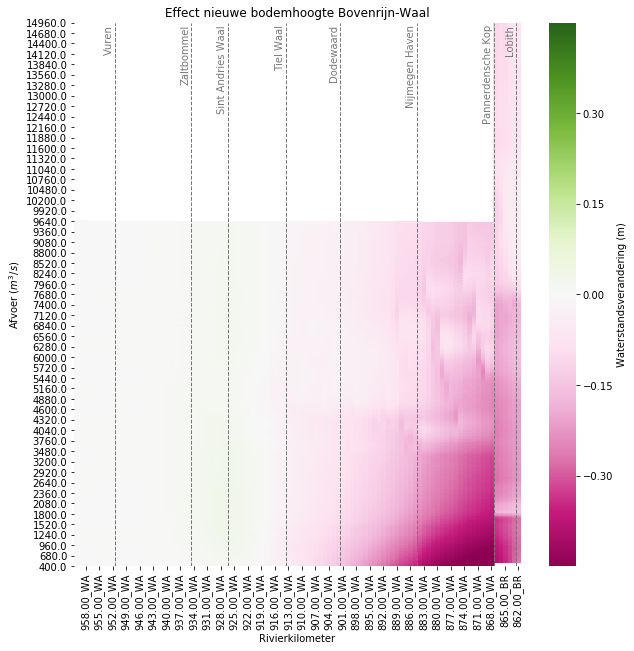

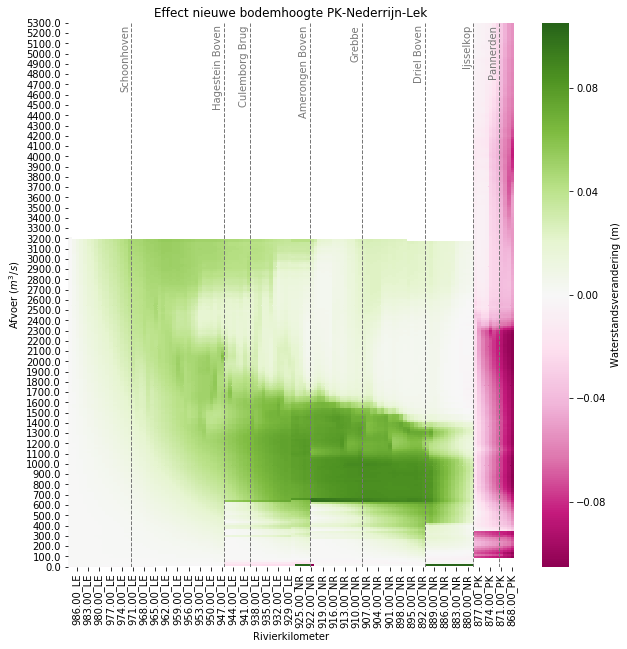

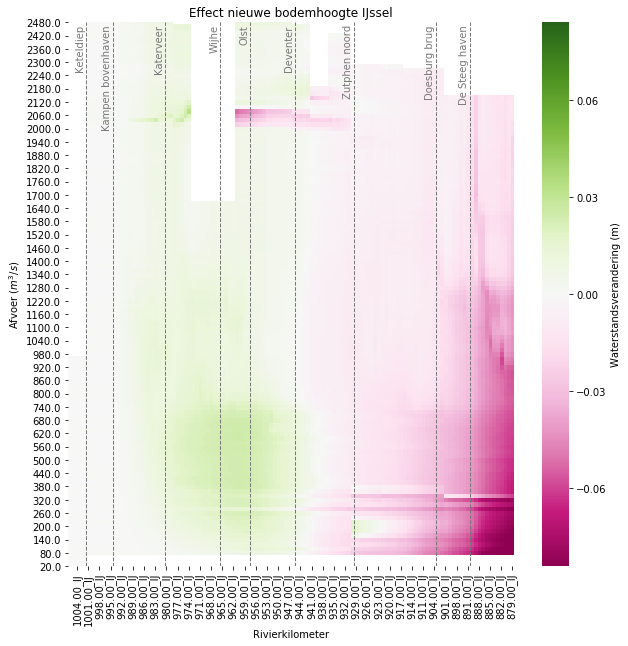

In [35]:
# Plot the change dH per dQ. Is there a discontinuity at 8000 m3/s?
for s in rkm.columns:
    l = rkm[s].dropna()

    f, ax = plt.subplots(ncols=1, figsize=(10,10))
    plt.sca(ax)
    data_bed2018 = QH[bedlevels[0]][l]
    data_bed2050 = QH[bedlevels[1]][l]
    data = (data_bed2050 - data_bed2018).dropna(how='all')
    vmax = data.abs().quantile(0.95).max()
    vmin = -vmax
    sns.heatmap(data, cmap='PiYG', vmin=vmin, vmax=vmax, ax=ax, cbar_kws={'label': 'Waterstandsverandering (m)'})
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.set_title(f'Effect nieuwe bodemhoogte {s}')
    plotMeetpuntenForRKM_heatmap(meetp, l)
    plt.ylabel('Afvoer ($m^3/s$)')
    plt.xlabel('Rivierkilometer')
    plt.savefig(figuresubdir / f'Heatmap_QH_{s}_change.png', dpi=300, bbox_inches='tight')
